In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd
from tqdm import tqdm

In [6]:
new_df = pd.read_csv('new_df_10.csv')

In [7]:
# read unique_types.csv into a list
unique_types = pd.read_csv('unique_types.csv')
unique_types = unique_types['type'].tolist()
print(len(unique_types))
# # delete the unique_types columns in new_df if the number of the type is less than 100 that not 0
# for col in unique_types:
#     if (new_df[col] != 0).sum() < 500:
#         new_df = new_df.drop(columns=[col])
#         # delete the type in the list
#         unique_types.remove(col)
        
print(f"Number of columns left for unique_types: {len(unique_types)}")

36
Number of columns left for unique_types: 36


In [8]:
# Calculate the frequency of the number 0 across all unique_types columns
zero_count = (new_df[unique_types] == 0).sum().sum()

# Calculate the total count of all numbers in unique_types columns
total_count = len(new_df) * len(unique_types)

# Calculate the overall percentage of the number 0
zero_percentage = (zero_count / total_count) * 100

# Print the percentage of the number 0
print(f"Percentage of 0: {zero_percentage:.2f}%")

Percentage of 0: 71.91%


In [9]:
for col in unique_types:
    if new_df[col].quantile(0.999) < new_df[col].max():
        new_df.loc[new_df[col] > new_df[col].quantile(0.999), col] = new_df[col].quantile(0.999)
    

In [10]:
zero_frequencies = (new_df[unique_types] == 0).sum() / len(new_df)

# >90% columns with 0
columns_to_drop = zero_frequencies[zero_frequencies > 0.9].index

# Drop the columns
new_df.drop(columns=columns_to_drop, inplace=True)

# Print the columns that were dropped
print(f"Deleted columns: {list(columns_to_drop)}")

Deleted columns: ['Noise - Commercial - Car/Truck Horn', 'Noise - Noise: Private Carting Noise (NQ1)', 'Noise - Noise, Other Animals (NR6)', 'Noise - House of Worship - Loud Music/Party', 'Noise - Commercial - Loud Television', 'Noise - Helicopter - NYPD', 'Collection Truck Noise - 21 Collection Truck Noise', 'Noise - Park - Loud Talking', 'Noise - Noise: Boat(Engine,Music,Etc) (NR10)', 'Noise - Noise: Manufacturing Noise (NK1)', 'Noise - House of Worship - Loud Talking', 'Noise - Helicopter - News Gathering', 'Noise - House of Worship - Banging/Pounding']


In [11]:
# delete the name of the columns that were dropped from the unique_types list
for col in columns_to_drop:
    unique_types.remove(col)

In [12]:
len(unique_types)

23

In [13]:
new_df[unique_types].describe()

Noise - Park - Loud Music/Party  \
count                     15362.000000   
mean                          1.788230   
std                          13.549313   
min                           0.000000   
25%                           0.000000   
50%                           0.000000   
75%                           0.000000   
max                         296.112000   

       Noise - Residential - Loud Music/Party  \
count                            15362.000000   
mean                                57.396531   
std                                103.461124   
min                                  0.000000   
25%                                  4.000000   
50%                                 18.000000   
75%                                 64.000000   
max                               1117.344000   

       Noise - Street/Sidewalk - Loud Talking  \
count                            15362.000000   
mean                                 7.576893   
std                                 26.192779   
min                                  0.000000   
25%                                  0.000000   
50%                                  1.000000   
75%                                  5.000000   
max                                426.639000   

       Noise - Vehicle - Car/Truck Music  Noise - Helicopter - Other  \
count                       15362.000000                15362.000000   
mean                           12.643075                    5.985579   
std                            47.298975                   74.223811   
min                             0.000000                    0.000000   
25%                             0.000000                    0.000000   
50%                             1.000000                    0.000000   
75%                             7.000000                    0.000000   
max                           699.307000                 1818.904000   

       Noise - Residential - Banging/Pounding  \
count                            15362.000000   
mean                                26.817387   
std                                 84.105368   
min                                  0.000000   
25%                                  1.000000   
50%                                  4.000000   
75%                                 19.000000   
max                               1353.419000   

       Noise - Street/Sidewalk - Loud Music/Party  \
count                                15362.000000   
mean                                    43.020458   
std                                    140.342288   
min                                      0.000000   
25%                                      1.000000   
50%                                      5.000000   
75%                                     23.000000   
max                                   1909.892000   

       Noise - Commercial - Loud Music/Party  \
count                           15362.000000   
mean                               13.231727   
std                                52.058697   
min                                 0.000000   
25%                                 0.000000   
50%                                 0.000000   
75%                                 3.000000   
max                               723.112000   

       Noise - Commercial - Loud Talking  Noise - Residential - Loud Talking  \
count                       15362.000000                        15362.000000   
mean                            1.114431                            6.477044   
std                             5.809202                           20.524680   
min                             0.000000                            0.000000   
25%                             0.000000                            0.000000   
50%                             0.000000                            1.000000   
75%                             0.000000                            6.000000   
max                            96.556000                          362.834000   

       ...  Noise - N

In [14]:
def calculate_weighted_boundaries_4_classes(df, unique_types):
    boundaries_per_dataset = []

    # Step 1: Calculate total complaint count per row
    df['total_complaint_count'] = df[unique_types].sum(axis=1)
    
    # Step 2: Calculate 4 quantile boundaries based on the total complaint count
    total_boundaries = {
        0: 0,  # No complaints
        1: df['total_complaint_count'].quantile(0.05),  # Low complaints
        2: df['total_complaint_count'].quantile(0.5),   # Moderate complaints
        3: df['total_complaint_count'].quantile(0.8)   # High complaints
    }

    # Step 3: Calculate weights for each unique_types column (e.g., based on mean or sum)
    column_weights = {col: df[col].mean() for col in unique_types}  # Example: use mean as weight

    # Initialize dictionary to store adjusted boundaries for each column
    boundaries_per_type = {}

    # Step 4: Adjust boundaries for each unique_types column based on weights
    for col in unique_types:
        # Use the total boundaries scaled by the weight of the column
        col_weight = column_weights[col]
        max_weight = max(column_weights.values())
        boundaries_per_type[col] = {
            level: total_boundaries[level] * col_weight / max_weight
            for level in total_boundaries
        }

    # Append boundaries for the current dataset to the list
    boundaries_per_dataset.append(boundaries_per_type)
    
    return boundaries_per_dataset

# Function to categorize values in unique_types columns based on weighted boundaries
def apply_weighted_boundaries_4_classes(df, unique_types, boundaries):
    def categorize(value, col_boundaries):
        # Assign category based on adjusted boundaries for 4 classes
        for category in range(3):
            if col_boundaries[category] <= value < col_boundaries[category + 1]:
                return category
        return 3  # Assign the highest category if the value is above the last boundary

    for col in unique_types:
        col_boundaries = boundaries[col]  # Get specific boundaries for the current column
        df[col] = df[col].apply(lambda x: categorize(x, col_boundaries))

# Example usage
boundaries_per_dataset = calculate_weighted_boundaries_4_classes(new_df, unique_types)  # Calculate weighted boundaries with 4 classes

apply_weighted_boundaries_4_classes(new_df, unique_types, boundaries_per_dataset[0])


In [15]:
new_df

h3_index       density  stripclub  sports_centre  gatehouse  \
0      8af05aa41747fff  0.000000e+00          0              0          0   
1      8af05aa65a07fff  2.627205e+06          0              0          0   
2      8af05ab4c75ffff  0.000000e+00          0              0          0   
3      8af05aa44cd7fff  2.064071e+06          0              0          0   
4      8af05ab4b08ffff  0.000000e+00          0              0          0   
...                ...           ...        ...            ...        ...   
15357  8af05aa46327fff  6.897379e+03          0              0          0   
15358  8af0587940f7fff  0.000000e+00          0              0          0   
15359  8af0587b4717fff  0.000000e+00          0              0          0   
15360  8af05bda44a7fff  2.251097e+03          0              0          0   
15361  8af05ab6ea1ffff  6.588970e+04          0              0          0   

       block  beauty_school  data_center  \
0          0              0            0   
1          0              0            0   
2          0              0            0   
3          0              0            0   
4          0              0            0   
...      ...            ...          ...   
15357      0              0            0   
15358      0              0            0   
15359      0              0            0   
15360      0              0            0   
15361      0              0            0   

       Noise - Noise: Construction Before/After Hours (NM1)  crossing  ...  \
0                                                      1           11  ...   
1                                                      1           11  ...   
2                                                      2           22  ...   
3                                                      0            6  ...   
4                                                      1           12  ...   
...                                                  ...          ...  ...   
15357                                                  0            1  ...   
15358                                                  0            0  ...   
15359                                                  0            1  ...   
15360                                                  1            0  ...   
15361                                                  0            1  ...   

       peninsula  industrial  carport  music  bowling  public_bookcase  \
0              0           0        0      0        0                0   
1              0           0        0      0        0                0   
2              0           0        0      0        0                0   
3              0           0        0      0        0                0   
4              0           0        0      0        0                0   
...          ...         ...      ...    ...      ...              ...   
15357          0           0        0      0        0                0   
15358          0           0        0      0        0                0   
15359          0           0        0      0        0                0   
15360          0           0        0      0        0                0   
15361          0           0        0      0        0                0   

       dog_toilet  summer_camp  Noise - Vehicle - Car/Truck Music  \
0               0            0                                  0   
1               0            0                                  1   
2               0            0                                  3   
3               0            0                                  1   
4               0            0                                  2   
...           ...          ...                                ...   
15357           0            0                                  0   
15358           0            0                                  0   
15359           0            0                                  0   
15360           0            0              

In [11]:
new_df[unique_types].describe()

Noise - Park - Loud Music/Party  \
count                     15362.000000   
mean                          0.309660   
std                           0.748235   
min                           0.000000   
25%                           0.000000   
50%                           0.000000   
75%                           0.000000   
max                           3.000000   

       Noise - Residential - Loud Music/Party  \
count                            15362.000000   
mean                                 1.149004   
std                                  0.733827   
min                                  0.000000   
25%                                  1.000000   
50%                                  1.000000   
75%                                  2.000000   
max                                  3.000000   

       Noise - Street/Sidewalk - Loud Talking  \
count                            15362.000000   
mean                                 0.810441   
std                                  0.848224   
min                                  0.000000   
25%                                  0.000000   
50%                                  1.000000   
75%                                  1.000000   
max                                  3.000000   

       Noise - Vehicle - Car/Truck Music  Noise - Helicopter - Other  \
count                       15362.000000                15362.000000   
mean                            0.855227                    0.222041   
std                             0.792436                    0.570161   
min                             0.000000                    0.000000   
25%                             0.000000                    0.000000   
50%                             1.000000                    0.000000   
75%                             1.000000                    0.000000   
max                             3.000000                    3.000000   

       Noise - Residential - Banging/Pounding  \
count                            15362.000000   
mean                                 1.004687   
std                                  0.757561   
min                                  0.000000   
25%                                  1.000000   
50%                                  1.000000   
75%                                  1.000000   
max                                  3.000000   

       Noise - Street/Sidewalk - Loud Music/Party  \
count                                15362.000000   
mean                                     0.938029   
std                                      0.770147   
min                                      0.000000   
25%                                      0.000000   
50%                                      1.000000   
75%                                      1.000000   
max                                      3.000000   

       Noise - Commercial - Loud Music/Party  \
count                           15362.000000   
mean                                0.616261   
std                                 0.854146   
min                                 0.000000   
25%                                 0.000000   
50%                                 0.000000   
75%                                 1.000000   
max                                 3.000000   

       Noise - Commercial - Loud Talking  Noise - Residential - Loud Talking  \
count                       15362.000000                        15362.000000   
mean                            0.323265                            0.888101   
std                             0.772832                            0.839842   
min                             0.000000                            0.000000   
25%                             0.000000                            0.000000   
50%                             0.000000                            1.000000   
75%                             0.000000                            1.000000   
max                             3.000000                            3.000000   

       ...  Noise - N

In [12]:
# Calculate the frequency of each number (0, 1, 2, 3) across all unique_types columns
number_counts = {num: (new_df[unique_types] == num).sum().sum() for num in range(4)}

# Calculate the total count of all numbers in unique_types columns
total_count = len(new_df) * len(unique_types)

# Calculate the overall percentage for each number
overall_percentages = {num: (count / total_count) * 100 for num, count in number_counts.items()}

# Print the percentage of each number
for num, percentage in overall_percentages.items():
    print(f"Number {num}: {percentage:.2f}%")


Number 0: 59.21%
Number 1: 23.48%
Number 2: 12.68%
Number 3: 4.62%


## Build a model

### RandomForest

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from tqdm import tqdm  # For displaying progress bar
import matplotlib.pyplot as plt

In [17]:
# Separate features and target
X = new_df.drop(columns=["h3_index"] + unique_types)  # Features (excluding 'h3_index' and target columns)
y = new_df[unique_types]  # Multi-column target variables (each column is a 4-class target)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
# Step 3: Variance Threshold - removing features with low variance
# Only features with variance above the threshold will be kept
var_thresh = VarianceThreshold(threshold=0.1)
X_train = var_thresh.fit_transform(X_train)
X_test = var_thresh.transform(X_test)  # Apply the same transformation to test data

print("Features after variance threshold:", X_train.shape[1])

Features after variance threshold: 439


In [19]:
 X_train.shape

(12289, 439)

In [20]:
# Step 4: Model-based Feature Selection using RandomForestClassifier
# Initialize RandomForest to estimate feature importance
model = RandomForestClassifier(n_estimators=100, random_state=46)
model.fit(X_train, y_train)

# Select features with importance greater than the mean importance
selector = SelectFromModel(model, threshold="mean")
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)  # Apply the same selection to test data

print("Features after model-based selection:", X_train.shape[1])

Features after model-based selection: 70


In [18]:
# # Step 5: PCA for dimensionality reduction
# # Use PCA to retain components explaining at least 90% of the variance
# pca = PCA(n_components=0.9)  # Retain enough components to explain 90% of the variance
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# print("Features after PCA reduction:", X_train.shape[1])

In [19]:
# Step 6: Train separate RandomForestClassifier for each target column
train_losses = []
train_accuracies = []
models = []  # List to hold models for each target column

# Training loop with early stopping based on the last 5 iterations
for i in tqdm(range(1, 101), desc="Training Progress"):
    column_losses = []
    column_accuracies = []
    column_models = []

    for col in range(y_train.shape[1]):
        # Initialize RandomForestClassifier with incremental trees
        model = RandomForestClassifier(n_estimators=i, max_depth=10, min_samples_split=5, random_state=46, n_jobs=-1)
        model.fit(X_train, y_train.iloc[:, col])

        # Predict on training data for current column
        y_train_pred = model.predict(X_train)
        
        # Calculate log loss and accuracy for the current column
        train_loss = log_loss(y_train.iloc[:, col], model.predict_proba(X_train))
        train_acc = accuracy_score(y_train.iloc[:, col], y_train_pred)
        
        # Append column results
        column_losses.append(train_loss)
        column_accuracies.append(train_acc)
        column_models.append(model)
    
    # Average the log loss and accuracy across all columns
    avg_train_loss = np.mean(column_losses)
    avg_train_acc = np.mean(column_accuracies)
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    models = column_models  # Update models with the latest trained models for each column

    # Early stopping condition:
    # 1. Check if the average loss reduction of the last 5 rounds is below threshold
    # 2. Check if the average accuracy improvement of the last 5 rounds is below threshold
    if i > 5:
        loss_drops = [train_losses[-j] - train_losses[-j-1] for j in range(1, 6)]
        acc_improvements = [train_accuracies[-j] - train_accuracies[-j-1] for j in range(1, 6)]
        if all(drop < 0.001 for drop in loss_drops) and all(improvement < 0.001 for improvement in acc_improvements):
            print(f"Early stopping at iteration {i}")
            break

Training Progress:  18%|█▊        | 18/100 [02:28<11:14,  8.23s/it]

Early stopping at iteration 19


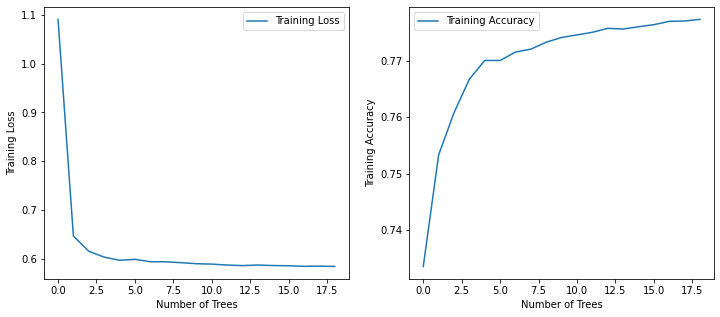

In [20]:
# Plotting the training loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot for training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Number of Trees")
plt.ylabel("Training Loss")
plt.legend()

# Plot for training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel("Number of Trees")
plt.ylabel("Training Accuracy")
plt.legend()

plt.show()

In [21]:
# Step 7: Evaluate on the test set
# Make predictions on test data for each model and column
y_test_pred = np.column_stack([model.predict(X_test) for model in models])

# Calculate and print the overall test accuracy by averaging accuracy for each column
column_accuracies = [
    accuracy_score(y_test.iloc[:, col], y_test_pred[:, col]) for col in range(y_test.shape[1])
]
overall_test_acc = np.mean(column_accuracies)
print("Overall Test Accuracy:", overall_test_acc)

# Compute and display the overall confusion matrix
# Flatten y_test and y_test_pred for a combined confusion matrix across all columns
y_test_combined = y_test.values.ravel()
y_test_pred_combined = y_test_pred.ravel()
cm = confusion_matrix(y_test_combined, y_test_pred_combined)
print("Overall Confusion Matrix:\n", cm)

# # Compute and display the confusion matrix for each label
# for i, col in enumerate(y_test.columns):
#     cm = confusion_matrix(y_test.iloc[:, i], y_test_pred[:, i])
#     print(f"Confusion Matrix for column {col}:\n", cm)


Overall Test Accuracy: 0.7231992529605682
Overall Confusion Matrix:
 [[38789  2760   396    36]
 [ 6132  9238   907    47]
 [ 3711  2599  2482   251]
 [ 1151   518  1056   606]]


In [22]:


# Make predictions on test data for each model and column
y_test_pred_rf = np.column_stack([model.predict(X_test) for model in models])

# Compute and display the overall confusion matrix for Random Forest
y_test_combined_rf = y_test.values.ravel()
y_test_pred_combined_rf = y_test_pred_rf.ravel()
cm_rf = confusion_matrix(y_test_combined_rf, y_test_pred_combined_rf)

# Calculate and print the accuracy for each class
class_accuracies_rf = cm_rf.diagonal() / cm_rf.sum(axis=1)
for i, accuracy in enumerate(class_accuracies_rf):
    print(f"Accuracy for class {i} in Random Forest: {accuracy:.2%}")

Accuracy for class 0 in Random Forest: 92.40%
Accuracy for class 1 in Random Forest: 56.59%
Accuracy for class 2 in Random Forest: 27.45%
Accuracy for class 3 in Random Forest: 18.19%


Training Progress:  60%|██████    | 60/100 [3:24:55<2:16:36, 204.92s/it]

Early stopping at iteration 61


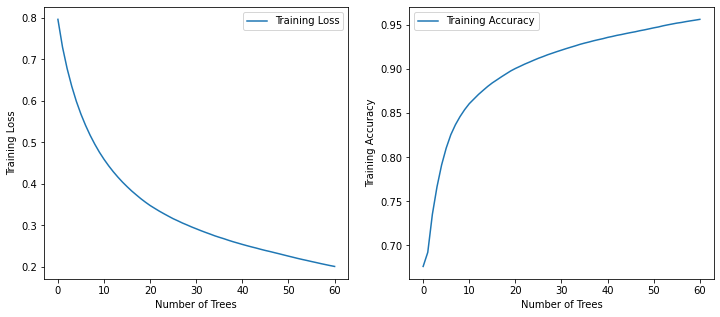

Accuracy for class 0 in GBDT: 89.78%
Accuracy for class 1 in GBDT: 55.92%
Accuracy for class 2 in GBDT: 36.97%
Accuracy for class 3 in GBDT: 31.70%
Overall Test Accuracy with GBDT: 0.7246423973174493
Overall Confusion Matrix with GBDT:
 [[37689  3263   863   166]
 [ 5518  9129  1501   176]
 [ 2911  2136  3343   653]
 [  818   295  1162  1056]]


In [31]:
from sklearn.ensemble import GradientBoostingClassifier  # Import GBDT model2
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from tqdm import tqdm  # For displaying progress bar
import matplotlib.pyplot as plt
import numpy as np  # Ensure np is imported

# Initialize lists to store training losses and accuracies
train_losses = []
train_accuracies = []
model2s = []  # List to hold models for each target column

# Training loop with early stopping based on the last 5 iterations
for i in tqdm(range(1, 101), desc="Training Progress"):
    column_losses = []
    column_accuracies = []
    column_model2s = []

    for col in range(y_train.shape[1]):
        # Initialize GradientBoostingClassifier (GBDT) with incremental estimators
        model2 = GradientBoostingClassifier(n_estimators=i, max_depth=10, min_samples_split=5, random_state=46)
        model2.fit(X_train, y_train.iloc[:, col])

        # Predict on training data for current column
        y_train_pred = model2.predict(X_train)
        
        # Calculate log loss and accuracy for the current column
        train_loss = log_loss(y_train.iloc[:, col], model2.predict_proba(X_train))
        train_acc = accuracy_score(y_train.iloc[:, col], y_train_pred)
        
        # Append column results
        column_losses.append(train_loss)
        column_accuracies.append(train_acc)
        column_model2s.append(model2)
    
    # Average the log loss and accuracy across all columns
    avg_train_loss = np.mean(column_losses)
    avg_train_acc = np.mean(column_accuracies)
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    model2s = column_model2s  # Update model2s with the latest trained model2s for each column

    # Early stopping condition:
    # 1. Check if the average loss reduction of the last 5 rounds is below threshold
    # 2. Check if the average accuracy improvement of the last 5 rounds is below threshold
    if i > 5:
        loss_drops = [train_losses[-j] - train_losses[-j-1] for j in range(1, 6)]
        acc_improvements = [train_accuracies[-j] - train_accuracies[-j-1] for j in range(1, 6)]
        if all(drop < 0.001 for drop in loss_drops) and all(improvement < 0.001 for improvement in acc_improvements):
            print(f"Early stopping at iteration {i}")
            break

# Plotting the training loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot for training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Number of Trees")
plt.ylabel("Training Loss")
plt.legend()

# Plot for training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel("Number of Trees")
plt.ylabel("Training Accuracy")
plt.legend()

plt.show()

# Step 7: Evaluate on the test set

# Make predictions on test data for each model2 and column
y_test_pred_gbdt = np.column_stack([model2.predict(X_test) for model2 in model2s])

# Compute and display the overall confusion matrix for GBDT
y_test_combined_gbdt = y_test.values.ravel()
y_test_pred_combined_gbdt = y_test_pred_gbdt.ravel()
cm_gbdt = confusion_matrix(y_test_combined_gbdt, y_test_pred_combined_gbdt)

# Calculate and print the accuracy for each class
class_accuracies_gbdt = cm_gbdt.diagonal() / cm_gbdt.sum(axis=1)
for i, accuracy in enumerate(class_accuracies_gbdt):
    print(f"Accuracy for class {i} in GBDT: {accuracy:.2%}")

# Calculate and print the overall test accuracy by averaging accuracy for each column
column_accuracies = [
    accuracy_score(y_test.iloc[:, col], y_test_pred_gbdt[:, col]) for col in range(y_test.shape[1])
]
overall_test_acc = np.mean(column_accuracies)
print("Overall Test Accuracy with GBDT:", overall_test_acc)

# Display the overall confusion matrix
print("Overall Confusion Matrix with GBDT:\n", cm_gbdt)


In [29]:
from lightgbm import LGBMClassifier  # Import LightGBM classifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from tqdm import tqdm  # For displaying progress bar
import matplotlib.pyplot as plt
import numpy as np  # Ensure np is imported

# Initialize lists to store training losses and accuracies
train_losses = []
train_accuracies = []
model3s = []  # List to hold model3s for each target column

# Training loop with early stopping based on the last 5 iterations
for i in tqdm(range(1, 101), desc="Training Progress"):
    column_losses = []
    column_accuracies = []
    column_model3s = []

    for col in range(y_train.shape[1]):
        # Initialize LightGBM with GPU support
        model3 = LGBMClassifier(
            n_estimators=i,
            max_depth=10,
            learning_rate=0.1,  # Adjust learning rate as needed
            min_child_samples=5,
            random_state=46,
            device='gpu',  # Use GPU acceleration
            verbose=-1     # Suppress detailed training logs
        )
        model3.fit(X_train, y_train.iloc[:, col])

        # Predict on training data for current column
        y_train_pred = model3.predict(X_train)
        
        # Calculate log loss and accuracy for the current column
        train_loss = log_loss(y_train.iloc[:, col], model3.predict_proba(X_train))
        train_acc = accuracy_score(y_train.iloc[:, col], y_train_pred)
        
        # Append column results
        column_losses.append(train_loss)
        column_accuracies.append(train_acc)
        column_model3s.append(model3)
    
    # Average the log loss and accuracy across all columns
    avg_train_loss = np.mean(column_losses)
    avg_train_acc = np.mean(column_accuracies)
    
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    model3s = column_model3s  # Update model3s with the latest trained model3s for each column

    # Early stopping condition:
    if i > 5:
        loss_drops = [train_losses[-j] - train_losses[-j-1] for j in range(1, 6)]
        acc_improvements = [train_accuracies[-j] - train_accuracies[-j-1] for j in range(1, 6)]
        if all(drop < 0.001 for drop in loss_drops) and all(improvement < 0.001 for improvement in acc_improvements):
            print(f"Early stopping at iteration {i}")
            break

# Continue with evaluation as in previous examples


Training Progress:  68%|██████▊   | 68/100 [46:42<21:58, 41.21s/it]

Early stopping at iteration 69


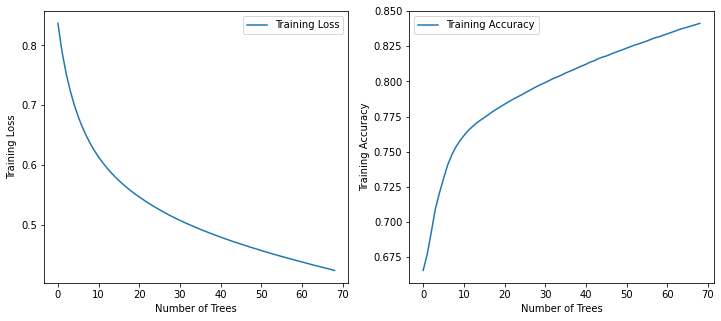

Accuracy for class 0 in GBDT: 91.04%
Accuracy for class 1 in GBDT: 55.48%
Accuracy for class 2 in GBDT: 37.26%
Accuracy for class 3 in GBDT: 34.40%
Overall Test Accuracy with GBDT: 0.7327777699175144
Overall Confusion Matrix with GBDT:
 [[38221  2870   735   155]
 [ 5613  9056  1501   154]
 [ 3023  2036  3369   615]
 [  831   252  1102  1146]]


In [30]:
# Plotting the training loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot for training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Number of Trees")
plt.ylabel("Training Loss")
plt.legend()

# Plot for training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.xlabel("Number of Trees")
plt.ylabel("Training Accuracy")
plt.legend()

plt.show()

# Step 7: Evaluate on the test set

# Make predictions on test data for each model3 and column
y_test_pred_gbdt = np.column_stack([model3.predict(X_test) for model3 in model3s])

# Compute and display the overall confusion matrix for GBDT
y_test_combined_gbdt = y_test.values.ravel()
y_test_pred_combined_gbdt = y_test_pred_gbdt.ravel()
cm_gbdt = confusion_matrix(y_test_combined_gbdt, y_test_pred_combined_gbdt)

# Calculate and print the accuracy for each class
class_accuracies_gbdt = cm_gbdt.diagonal() / cm_gbdt.sum(axis=1)
for i, accuracy in enumerate(class_accuracies_gbdt):
    print(f"Accuracy for class {i} in GBDT: {accuracy:.2%}")

# Calculate and print the overall test accuracy by averaging accuracy for each column
column_accuracies = [
    accuracy_score(y_test.iloc[:, col], y_test_pred_gbdt[:, col]) for col in range(y_test.shape[1])
]
overall_test_acc = np.mean(column_accuracies)
print("Overall Test Accuracy with GBDT:", overall_test_acc)

# Display the overall confusion matrix
print("Overall Confusion Matrix with GBDT:\n", cm_gbdt)

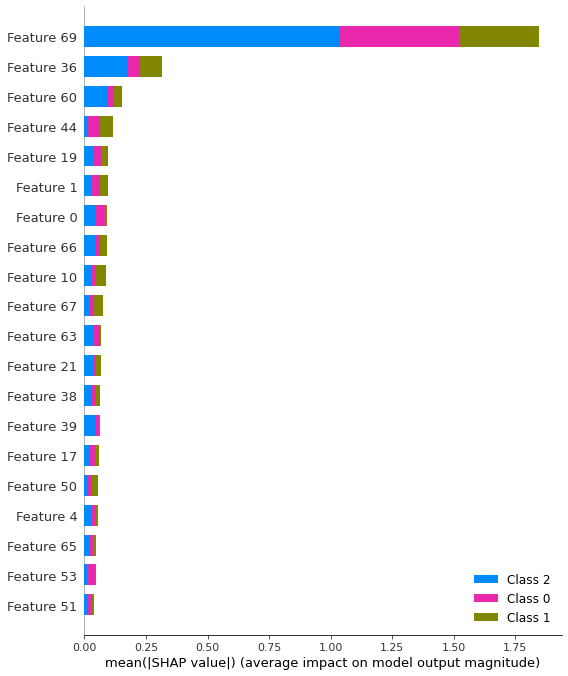

In [33]:
import shap
explainer_rf = shap.TreeExplainer(model3)  
shap_values_rf = explainer_rf.shap_values(X_test)  
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")

d:\Anaconda\envs\tf_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


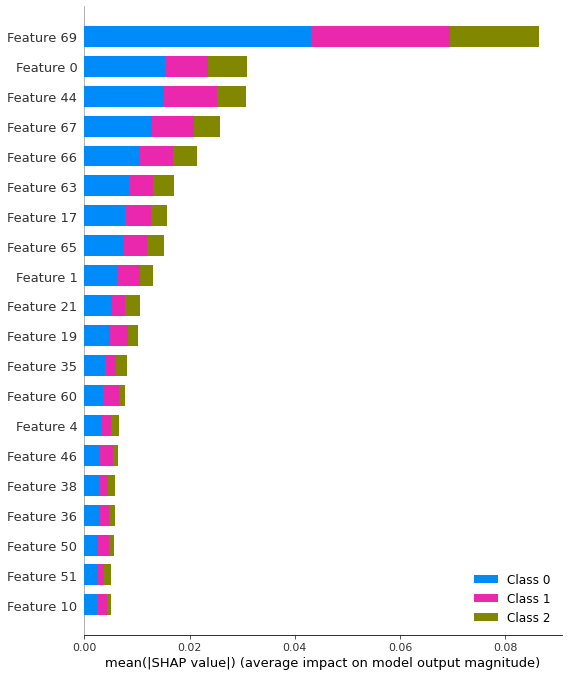

In [23]:
import shap
explainer_rf = shap.TreeExplainer(model)  
shap_values_rf = explainer_rf.shap_values(X_test)  
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")


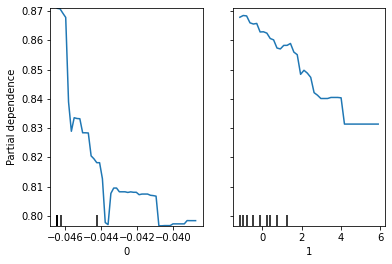

In [26]:
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(model, X_test, [0, 1], target=0, grid_resolution=50)
plt.show()

In [29]:
from lime import lime_tabular
explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names=X.columns, mode='classification')
exp_rf = explainer.explain_instance(X_test[0], model.predict_proba) 
exp_rf.show_in_notebook()


## Neural network

### Autoencoders for Feature Extraction + Neural Network Regression

Framework Overview

1. Autoencoder for Dimensionality Reduction: The autoencoder learns a compressed representation of the features.
2. Neural Network Regression Model: The compressed features are then fed into a regression network to predict counts for each type in unique_types.


In [56]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# Separate features and target
X = new_df.drop(columns=["h3_index"] + unique_types)  # Features (excluding 'h3_index' and target columns)
y = new_df[unique_types]  # Multi-column target variables (each column is a 4-class target)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=46)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=46)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# DataLoader for batch processing
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

# Define Autoencoder Architecture with Fewer Neurons and Smaller Learning Rate
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder with dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Define dimensions
input_dim = X_train.shape[1]  # Number of features
# latent_dim = 16  # Dimension of compressed space

# # Initialize autoencoder and optimizer with a smaller learning rate
# autoencoder = Autoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)
criterion_ae = nn.MSELoss()
# optimizer_ae = optim.Adam(autoencoder.parameters(), lr=0.0001)  # Further reduced learning rate

# Train Autoencoder with early stopping
epochs_ae = 1000
early_stopping_rounds = 5
tolerance = 1e-4
train_losses_ae, val_losses_ae = [], []
train_accuracies_ae, val_accuracies_ae = [], []  # Record accuracies
best_train_loss = float("inf")
no_improve_rounds = 0



Training on device: cuda


In [38]:
# Example of grid search for latent_dim
latent_dims = [4, 8, 16, 32, 64]  # Range of latent dimensions to test
results = []

for latent_dim in tqdm(latent_dims, desc="Grid Search for Latent Dim"):
    # Initialize and train the autoencoder with the current latent_dim
    autoencoder = Autoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)
    best_val_loss = float("inf")
    no_improve_rounds = 0

    # Train autoencoder with early stopping
    for epoch in tqdm(range(epochs_ae), desc="Training Autoencoder"):
        autoencoder.train()
        epoch_train_loss = 0
        for X_batch, _ in train_loader:
            X_batch = X_batch.to(device)
            _, decoded = autoencoder(X_batch)
            loss = criterion_ae(decoded, X_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        avg_train_loss = epoch_train_loss / len(train_loader)

        # Validation
        autoencoder.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, _ in val_loader:
                X_batch = X_batch.to(device)
                _, decoded = autoencoder(X_batch)
                val_loss += criterion_ae(decoded, X_batch).item()
        avg_val_loss = val_loss / len(val_loader)

        # Early stopping
        if avg_val_loss < best_val_loss - tolerance:
            best_val_loss = avg_val_loss
            no_improve_rounds = 0
        else:
            no_improve_rounds += 1
            if no_improve_rounds >= early_stopping_rounds:
                break

    # Record the performance of the current latent_dim
    results.append((latent_dim, best_val_loss))

# Find the optimal latent_dim based on validation loss
best_latent_dim, best_loss = min(results, key=lambda x: x[1])
print(f"Optimal latent_dim: {best_latent_dim}, Validation Loss: {best_loss}")


Grid Search for Latent Dim: 100%|██████████| 5/5 [02:07<00:00, 25.48s/it]

Optimal latent_dim: 64, Validation Loss: 0.9511449833710989


In [ ]:
latent_dim = best_latent_dim  # Dimension of compressed space
# Initialize autoencoder and optimizer with a smaller learning rate
autoencoder = Autoencoder(input_dim=input_dim, latent_dim=latent_dim).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=0.0001)  # Further reduced learning rate
for epoch in tqdm(range(epochs_ae), desc="Training Autoencoder"):
    autoencoder.train()
    epoch_train_loss = 0
    
    for X_batch, _ in train_loader:
        X_batch = X_batch.to(device)
        
        _, decoded = autoencoder(X_batch)
        loss = criterion_ae(decoded, X_batch)  # Reconstruction loss

        optimizer_ae.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer_ae.step()
        epoch_train_loss += loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses_ae.append(avg_train_loss)

    # Early stopping based on tolerance
    if avg_train_loss < best_train_loss - tolerance:
        best_train_loss = avg_train_loss  # Update best loss only if it improves by more than tolerance
        no_improve_rounds = 0  # Reset no_improve_rounds if there is a significant improvement
    else:
        no_improve_rounds += 1  # Increment if there is no significant improvement

    if no_improve_rounds >= early_stopping_rounds:
        print("Early stopping for Autoencoder.")
        break

    # Validation loss (optional, only for monitoring)
    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            _, decoded = autoencoder(X_batch)
            val_loss += criterion_ae(decoded, X_batch).item()
    val_losses_ae.append(val_loss / len(val_loader))


Training Autoencoder:  12%|█▏        | 118/1000 [00:44<05:29,  2.67it/s]

Early stopping for Autoencoder.


In [59]:
# Extract compressed features using trained autoencoder
autoencoder.eval()
X_train_compressed = autoencoder.encoder(X_train_tensor.to(device)).detach()
X_val_compressed = autoencoder.encoder(X_val_tensor.to(device)).detach()
X_test_compressed = autoencoder.encoder(X_test_tensor.to(device)).detach()


In [60]:
# Define Regression Model using compressed features
class RegressionModel(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(RegressionModel, self).__init__()
        self.regressor = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.regressor(x)

output_dim = y_train.shape[1] * 4  # Number of targets as one-hot for each column
regression_model = RegressionModel(latent_dim=latent_dim, output_dim=output_dim).to(device)
criterion_reg = nn.CrossEntropyLoss()
optimizer_reg = optim.Adam(regression_model.parameters(), lr=0.0005)  # Smaller learning rate

# Training the Regression Model with early stopping and accuracy recording
epochs_reg = 1000
train_losses_reg, val_losses_reg = [], []
train_accuracies_reg, val_accuracies_reg = [], []
best_train_loss = float("inf")
no_improve_rounds = 0

for epoch in tqdm(range(epochs_reg), desc="Training Regression Model"):
    regression_model.train()
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Encode batch and perform regression
        encoded_batch = autoencoder.encoder(X_batch)
        outputs = regression_model(encoded_batch)
        loss = criterion_reg(outputs.view(-1, 4), y_batch.view(-1))  # CrossEntropy loss

        optimizer_reg.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(regression_model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer_reg.step()
        epoch_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = outputs.view(-1, 4).max(1)
        correct_train += (predicted == y_batch.view(-1)).sum().item()
        total_train += y_batch.view(-1).size(0)
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses_reg.append(avg_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies_reg.append(train_accuracy)

    # Early stopping based on tolerance
    if avg_train_loss < best_train_loss - tolerance:
        best_train_loss = avg_train_loss  # Update best loss only if improvement is significant
        no_improve_rounds = 0  # Reset no_improve_rounds if there is significant improvement
    else:
        no_improve_rounds += 1  # Increment if no significant improvement

    if no_improve_rounds >= early_stopping_rounds:
        print("Early stopping for Regression Model.")
        break

    # Validation loss and accuracy
    regression_model.eval()
    with torch.no_grad():
        val_loss = 0
        correct_val = 0
        total_val = 0
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            encoded_batch = autoencoder.encoder(X_batch)
            outputs = regression_model(encoded_batch)
            val_loss += criterion_reg(outputs.view(-1, 4), y_batch.view(-1)).item()

            # Validation accuracy calculation
            _, predicted = outputs.view(-1, 4).max(1)
            correct_val += (predicted == y_batch.view(-1)).sum().item()
            total_val += y_batch.view(-1).size(0)

    val_losses_reg.append(val_loss / len(val_loader))
    val_accuracy = correct_val / total_val
    val_accuracies_reg.append(val_accuracy)


Training Regression Model:   6%|▌         | 56/1000 [00:34<09:47,  1.61it/s]

Early stopping for Regression Model.


In [61]:
# predict the test data
regression_model.eval()
with torch.no_grad():
    encoded_test = autoencoder.encoder(X_test_tensor.to(device))
    outputs_test = regression_model(encoded_test)
    y_pred = outputs_test.view(-1, 4).argmax(dim=1).cpu().numpy()
    
# Calculate overall accuracy
y_true = y_test.values.flatten()
overall_accuracy = accuracy_score(y_true, y_pred)
print(f"\nOverall Test Accuracy across all target columns: {overall_accuracy:.4f}")

from sklearn.metrics import confusion_matrix

# Collect predictions and targets for confusion matrix
all_predictions = []
all_targets = []

regression_model.eval()
with torch.no_grad():
    val_loss = 0
    correct_val = 0
    total_val = 0
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        encoded_batch = autoencoder.encoder(X_batch)
        outputs = regression_model(encoded_batch)
        val_loss += criterion_reg(outputs.view(-1, 4), y_batch.view(-1)).item()

        # Get predictions
        _, predicted = outputs.view(-1, 4).max(1)
        
        # Append predictions and targets for confusion matrix
        all_predictions.append(predicted.cpu().numpy())
        all_targets.append(y_batch.view(-1).cpu().numpy())

        # Accuracy calculation
        correct_val += (predicted == y_batch.view(-1)).sum().item()
        total_val += y_batch.view(-1).size(0)

# Flatten lists of predictions and targets
all_predictions = np.concatenate(all_predictions)
all_targets = np.concatenate(all_targets)

# Compute the overall confusion matrix
cm = confusion_matrix(all_targets, all_predictions)
print("Overall Confusion Matrix:\n", cm)

# Calculate and print the accuracy for each class
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for i, accuracy in enumerate(class_accuracies):
    print(f"Accuracy for class {i}: {accuracy:.2%}")



Overall Test Accuracy across all target columns: 0.7008
Overall Confusion Matrix:
 [[30353  2939   368    41]
 [ 5064  7166   811    39]
 [ 3111  2020  1740   186]
 [ 1010   409   787   490]]
Accuracy for class 0: 90.07%
Accuracy for class 1: 54.79%
Accuracy for class 2: 24.66%
Accuracy for class 3: 18.18%


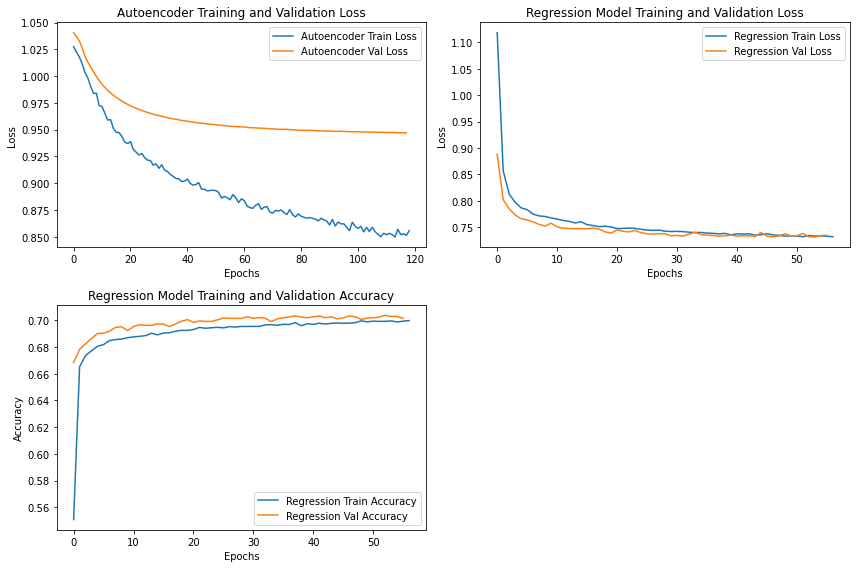

In [62]:
# Plot Loss and Accuracy Curves
plt.figure(figsize=(12, 8))

# Autoencoder Loss Curve
plt.subplot(2, 2, 1)
plt.plot(train_losses_ae, label="Autoencoder Train Loss")
plt.plot(val_losses_ae, label="Autoencoder Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Autoencoder Training and Validation Loss")
plt.legend()

# Regression Model Loss Curve
plt.subplot(2, 2, 2)
plt.plot(train_losses_reg, label="Regression Train Loss")
plt.plot(val_losses_reg, label="Regression Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Regression Model Training and Validation Loss")
plt.legend()

# Regression Model Accuracy Curve
plt.subplot(2, 2, 3)
plt.plot(train_accuracies_reg, label="Regression Train Accuracy")
plt.plot(val_accuracies_reg, label="Regression Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Regression Model Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


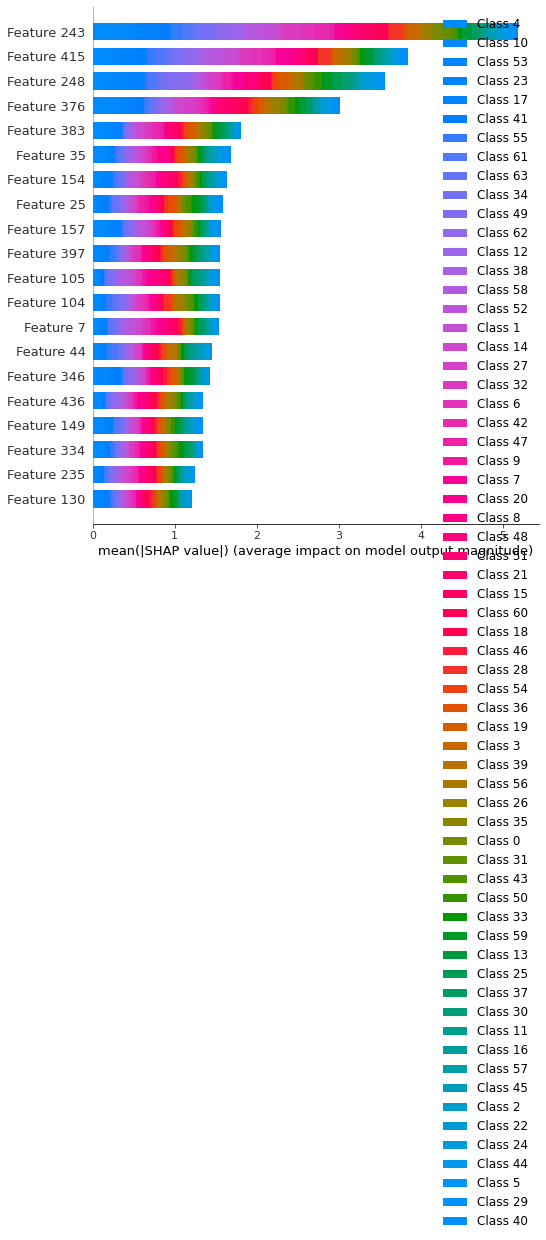

In [67]:
import shap

# explainer_nn = shap.DeepExplainer(autoencoder.encoder, X_train_tensor.to(device))
# shap_values_nn = explainer_nn.shap_values(X_test_tensor.to(device))

# shap.summary_plot(shap_values_nn, X_test_tensor, plot_type="bar", feature_names=X.columns)

# Example for SHAP with sample size limitation
background = X_train_tensor[:20].to(device)  
explainer_nn = shap.DeepExplainer(autoencoder.encoder, background)
shap_values_nn = explainer_nn.shap_values(X_test_tensor[:100].to(device))
shap.summary_plot(shap_values_nn, X_test_tensor[:100], plot_type="bar")

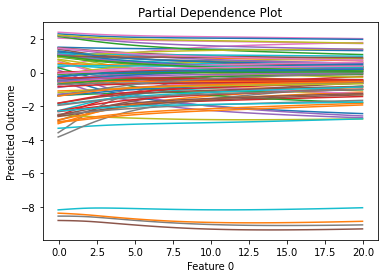

In [69]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pdp(model, feature_idx, X, feature_name=None):
    values = []
    feature_range = np.linspace(X[:, feature_idx].min().item(), X[:, feature_idx].max().item(), 50)
    for val in feature_range:
        X_temp = X.clone().detach()  
        X_temp[:, feature_idx] = val
        encoded_batch = autoencoder.encoder(X_temp.to(device))
        preds = model(encoded_batch).cpu().detach().numpy()
        values.append(preds.mean(axis=0))
    
    plt.plot(feature_range, values)
  
    plt.xlabel(feature_name if feature_name else f"Feature {feature_idx}")
    plt.ylabel("Predicted Outcome")
    plt.title("Partial Dependence Plot")
    plt.show()

# 调用 plot_pdp 时传入特征名称
plot_pdp(regression_model, feature_idx=0, X=X_test_tensor, feature_name="Feature 0")  



In [80]:
import numpy as np
from lime import lime_tabular
import torch

# Convert X_train_tensor to a numpy array if it is a PyTorch tensor
X_train_np = X_train_tensor.cpu().numpy() if isinstance(X_train_tensor, torch.Tensor) else X_train_tensor

# Define the LIME explainer using training data
explainer = lime_tabular.LimeTabularExplainer(
    X_train_np, 
    feature_names=X.columns, 
    mode='classification',
    class_names=[f"Class {i}" for i in range(4)]  # Define class names for readability
)

# Define a custom prediction function for LIME that returns probability scores
def predict_fn(data):
    # Convert input data to a PyTorch tensor
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    
    # Pass data through the autoencoder's encoder to get compressed features
    encoded_data = autoencoder.encoder(data_tensor)
    
    # Pass encoded data through the regression model to get raw outputs
    outputs = regression_model(encoded_data)
    
    # Reshape the output to (-1, 23, 4) for each target variable's class probabilities
    outputs = outputs.view(-1, 23, 4)
    
    # Apply softmax to get probabilities for each class in each target variable
    probabilities = torch.softmax(outputs, dim=2)  # Shape: (batch_size, 23, 4)
    
    # Flatten probabilities to match LIME's expected single output format
    flattened_probabilities = probabilities.cpu().detach().numpy().reshape(-1, 23 * 4)  # Shape: (batch_size, 23 * 4)
    
    return flattened_probabilities  # Return as a numpy array for LIME compatibility

# Ensure X_test is in numpy format
X_test_np = X_test_tensor.cpu().numpy() if isinstance(X_test_tensor, torch.Tensor) else X_test_tensor

# Use LIME to explain the first test sample
exp_nn = explainer.explain_instance(X_test_np[0], predict_fn, num_features=10)  # Explain top 10 important features
exp_nn.show_in_notebook()  # Display explanation in notebook


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.

                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


### TabNet + Neural Network Regression

In [83]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from pytorch_tabnet.tab_model import TabNetRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error
from itertools import product
import csv

# Separate features and target
X = new_df.drop(columns=["h3_index"] + unique_types)  # Features (excluding 'h3_index' and target columns)
y = new_df[unique_types]  # Multi-column target variables (each column is a 4-class target)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train_full, X_test, y_train_full, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=46)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=46)

# Convert targets to numpy arrays for TabNet
y_train_np = y_train.values
y_val_np = y_val.values


In [132]:
import time
from tqdm import tqdm

# Define parameter search space
param_grid = {
    "n_d": [8, 16, 32],
    "n_a": [8, 16, 32],
    "n_steps": [3, 5],
    "gamma": [1.5],
    "lambda_sparse": [0.001],
    "optimizer_params": [{"lr": 0.1}, {"lr": 0.05},  {"lr": 0.005}, {"lr": 0.0005}],
    "mask_type": ["entmax"]
}

# Get all parameter combinations
param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

# Initialize CSV file to save results
csv_filename = "tabnet_hyperparameter_search_results3.csv"
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    header = param_names + ["train_loss", "val_loss", "rmse"]
    writer.writerow(header)

# Start parameter search
start_time = time.time()
best_rmse = float("inf")
best_params = None

for params in tqdm(param_combinations, desc="Hyperparameter Search"):
    param_dict = dict(zip(param_names, params))
    
    # Initialize TabNet model
    tabnet_model = TabNetRegressor(
        n_d=param_dict["n_d"],
        n_a=param_dict["n_a"],
        n_steps=param_dict["n_steps"],
        gamma=param_dict["gamma"],
        lambda_sparse=param_dict["lambda_sparse"],
        optimizer_fn=torch.optim.Adam,
        optimizer_params=param_dict["optimizer_params"],
        mask_type=param_dict["mask_type"],
        verbose=0  # Set verbose to 0 to disable training logs
    )

    # Set maximum number of epochs and early stopping
    max_epochs = 1000
    early_stopping_rounds = 5

    # Train the model
    tabnet_model.fit(
        X_train=X_train,
        y_train=y_train_np,
        eval_set=[(X_train, y_train_np), (X_val, y_val_np)],
        max_epochs=max_epochs,
        patience=early_stopping_rounds,
        eval_metric=['rmse'],
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )
    
    # Calculate training loss and validation loss
    train_loss = mean_squared_error(y_train_np, tabnet_model.predict(X_train))
    val_loss = mean_squared_error(y_val_np, tabnet_model.predict(X_val))
    rmse = np.sqrt(val_loss)  # Use RMSE as the final evaluation metric

    # Save results to CSV file
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        result_row = list(params) + [train_loss, val_loss, rmse]
        writer.writerow(result_row)

    # Update best parameters if current RMSE is lower
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = param_dict

    print(f"Finished training with params: {param_dict}")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, RMSE: {rmse:.4f}")
    
end_time = time.time()
time_elapsed = end_time - start_time

# Print the best parameters after all searches
print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse:.4f}")
print(f"Time Elapsed: {time_elapsed:.2f} seconds")

Hyperparameter Search:   0%|          | 0/72 [00:00<?, ?it/s]


Early stopping occurred at epoch 24 with best_epoch = 19 and best_val_1_rmse = 0.65461


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:   1%|▏         | 1/72 [00:16<19:25, 16.41s/it]

Finished training with params: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.1}, 'mask_type': 'entmax'}
Train Loss: 0.4175, Val Loss: 0.4285, RMSE: 0.6546

Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_1_rmse = 0.67649


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:   3%|▎         | 2/72 [00:23<13:03, 11.19s/it]

Finished training with params: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.05}, 'mask_type': 'entmax'}
Train Loss: 0.4583, Val Loss: 0.4576, RMSE: 0.6765

Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_1_rmse = 0.73266


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:   4%|▍         | 3/72 [00:35<12:49, 11.15s/it]

Finished training with params: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.005}, 'mask_type': 'entmax'}
Train Loss: 0.9042, Val Loss: 0.5368, RMSE: 0.7327

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.08212


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:   6%|▌         | 4/72 [00:39<09:35,  8.46s/it]

Finished training with params: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.0005}, 'mask_type': 'entmax'}
Train Loss: 1.4022, Val Loss: 1.1710, RMSE: 1.0821

Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_1_rmse = 0.68773


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:   7%|▋         | 5/72 [00:49<10:11,  9.13s/it]

Finished training with params: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.1}, 'mask_type': 'entmax'}
Train Loss: 0.4843, Val Loss: 0.4730, RMSE: 0.6877

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_1_rmse = 0.67066


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:   8%|▊         | 6/72 [01:03<11:41, 10.62s/it]

Finished training with params: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.05}, 'mask_type': 'entmax'}
Train Loss: 0.7112, Val Loss: 0.4498, RMSE: 0.6707

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.09375


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  10%|▉         | 7/72 [01:09<09:52,  9.11s/it]

Finished training with params: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.005}, 'mask_type': 'entmax'}
Train Loss: 1.3396, Val Loss: 1.1963, RMSE: 1.0937

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.09989


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  11%|█         | 8/72 [01:15<08:42,  8.16s/it]

Finished training with params: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.0005}, 'mask_type': 'entmax'}
Train Loss: 1.3218, Val Loss: 1.2098, RMSE: 1.0999

Early stopping occurred at epoch 18 with best_epoch = 13 and best_val_1_rmse = 0.65098


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  12%|█▎        | 9/72 [01:27<09:55,  9.46s/it]

Finished training with params: {'n_d': 8, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.1}, 'mask_type': 'entmax'}
Train Loss: 0.4317, Val Loss: 0.4238, RMSE: 0.6510

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_1_rmse = 0.65632


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  14%|█▍        | 10/72 [01:37<09:53,  9.58s/it]

Finished training with params: {'n_d': 8, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.05}, 'mask_type': 'entmax'}
Train Loss: 0.4419, Val Loss: 0.4308, RMSE: 0.6563

Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_1_rmse = 0.69726


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  15%|█▌        | 11/72 [01:51<11:15, 11.07s/it]

Finished training with params: {'n_d': 8, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.005}, 'mask_type': 'entmax'}
Train Loss: 0.4925, Val Loss: 0.4862, RMSE: 0.6973

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.09072


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  17%|█▋        | 12/72 [01:56<09:05,  9.10s/it]

Finished training with params: {'n_d': 8, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.0005}, 'mask_type': 'entmax'}
Train Loss: 1.2115, Val Loss: 1.1897, RMSE: 1.0907

Early stopping occurred at epoch 27 with best_epoch = 22 and best_val_1_rmse = 0.66116


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  18%|█▊        | 13/72 [02:21<13:32, 13.78s/it]

Finished training with params: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.1}, 'mask_type': 'entmax'}
Train Loss: 0.4718, Val Loss: 0.4371, RMSE: 0.6612

Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_1_rmse = 0.6929


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  19%|█▉        | 14/72 [02:41<15:12, 15.74s/it]

Finished training with params: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.05}, 'mask_type': 'entmax'}
Train Loss: 0.4676, Val Loss: 0.4801, RMSE: 0.6929

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.7907


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  21%|██        | 15/72 [02:47<12:12, 12.86s/it]

Finished training with params: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.005}, 'mask_type': 'entmax'}
Train Loss: 1.4905, Val Loss: 3.2066, RMSE: 1.7907

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_1_rmse = 1.35044


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  22%|██▏       | 16/72 [02:56<10:50, 11.62s/it]

Finished training with params: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.0005}, 'mask_type': 'entmax'}
Train Loss: 2.0253, Val Loss: 1.8237, RMSE: 1.3504

Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_1_rmse = 0.67149


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  24%|██▎       | 17/72 [03:07<10:37, 11.60s/it]

Finished training with params: {'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.1}, 'mask_type': 'entmax'}
Train Loss: 0.4574, Val Loss: 0.4509, RMSE: 0.6715

Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_1_rmse = 0.65155


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  25%|██▌       | 18/72 [03:22<11:17, 12.55s/it]

Finished training with params: {'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.05}, 'mask_type': 'entmax'}
Train Loss: 0.4205, Val Loss: 0.4245, RMSE: 0.6515

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.31845


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  26%|██▋       | 19/72 [03:27<08:57, 10.13s/it]

Finished training with params: {'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.005}, 'mask_type': 'entmax'}
Train Loss: 1.4010, Val Loss: 1.7383, RMSE: 1.3185

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.09296


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  28%|██▊       | 20/72 [03:31<07:19,  8.45s/it]

Finished training with params: {'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.0005}, 'mask_type': 'entmax'}
Train Loss: 1.4354, Val Loss: 1.1946, RMSE: 1.0930

Early stopping occurred at epoch 21 with best_epoch = 16 and best_val_1_rmse = 0.6906


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  29%|██▉       | 21/72 [03:51<10:04, 11.86s/it]

Finished training with params: {'n_d': 8, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.1}, 'mask_type': 'entmax'}
Train Loss: 0.4659, Val Loss: 0.4769, RMSE: 0.6906

Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_1_rmse = 0.66621


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  31%|███       | 22/72 [04:10<11:41, 14.03s/it]

Finished training with params: {'n_d': 8, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.05}, 'mask_type': 'entmax'}
Train Loss: 0.4484, Val Loss: 0.4438, RMSE: 0.6662

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.09767


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  32%|███▏      | 23/72 [04:16<09:32, 11.68s/it]

Finished training with params: {'n_d': 8, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.005}, 'mask_type': 'entmax'}
Train Loss: 1.5191, Val Loss: 1.2049, RMSE: 1.0977

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.10515


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  33%|███▎      | 24/72 [04:22<08:01, 10.03s/it]

Finished training with params: {'n_d': 8, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.0005}, 'mask_type': 'entmax'}
Train Loss: 1.2193, Val Loss: 1.2213, RMSE: 1.1051

Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_1_rmse = 0.65572


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  35%|███▍      | 25/72 [04:34<08:17, 10.58s/it]

Finished training with params: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.1}, 'mask_type': 'entmax'}
Train Loss: 0.4268, Val Loss: 0.4300, RMSE: 0.6557

Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_1_rmse = 0.66672


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  36%|███▌      | 26/72 [04:43<07:38,  9.98s/it]

Finished training with params: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.05}, 'mask_type': 'entmax'}
Train Loss: 0.4679, Val Loss: 0.4445, RMSE: 0.6667

Early stopping occurred at epoch 26 with best_epoch = 21 and best_val_1_rmse = 0.6824


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  38%|███▊      | 27/72 [05:00<09:02, 12.06s/it]

Finished training with params: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.005}, 'mask_type': 'entmax'}
Train Loss: 0.4810, Val Loss: 0.4657, RMSE: 0.6824

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.13711


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  39%|███▉      | 28/72 [05:04<07:08,  9.75s/it]

Finished training with params: {'n_d': 16, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.0005}, 'mask_type': 'entmax'}
Train Loss: 1.5108, Val Loss: 1.2930, RMSE: 1.1371

Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_1_rmse = 0.68063


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  40%|████      | 29/72 [05:22<08:44, 12.19s/it]

Finished training with params: {'n_d': 16, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.1}, 'mask_type': 'entmax'}
Train Loss: 0.4609, Val Loss: 0.4633, RMSE: 0.6806

Early stopping occurred at epoch 29 with best_epoch = 24 and best_val_1_rmse = 0.65423


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  42%|████▏     | 30/72 [05:53<12:31, 17.90s/it]

Finished training with params: {'n_d': 16, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.05}, 'mask_type': 'entmax'}
Train Loss: 0.4269, Val Loss: 0.4280, RMSE: 0.6542

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_1_rmse = 1.0019


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  43%|████▎     | 31/72 [06:43<18:46, 27.47s/it]

Finished training with params: {'n_d': 16, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.005}, 'mask_type': 'entmax'}
Train Loss: 2.1320, Val Loss: 1.0038, RMSE: 1.0019

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.18443


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  44%|████▍     | 32/72 [07:05<17:08, 25.72s/it]

Finished training with params: {'n_d': 16, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.0005}, 'mask_type': 'entmax'}
Train Loss: 1.2400, Val Loss: 1.4029, RMSE: 1.1844

Early stopping occurred at epoch 17 with best_epoch = 12 and best_val_1_rmse = 0.6472


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  46%|████▌     | 33/72 [07:45<19:36, 30.17s/it]

Finished training with params: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.1}, 'mask_type': 'entmax'}
Train Loss: 0.4185, Val Loss: 0.4189, RMSE: 0.6472

Early stopping occurred at epoch 13 with best_epoch = 8 and best_val_1_rmse = 0.66139


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  47%|████▋     | 34/72 [08:17<19:27, 30.71s/it]

Finished training with params: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.05}, 'mask_type': 'entmax'}
Train Loss: 0.4356, Val Loss: 0.4374, RMSE: 0.6614

Early stopping occurred at epoch 21 with best_epoch = 16 and best_val_1_rmse = 0.69307


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  49%|████▊     | 35/72 [09:08<22:34, 36.62s/it]

Finished training with params: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.005}, 'mask_type': 'entmax'}
Train Loss: 0.4842, Val Loss: 0.4803, RMSE: 0.6931

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.09535


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  50%|█████     | 36/72 [09:23<18:05, 30.15s/it]

Finished training with params: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.0005}, 'mask_type': 'entmax'}
Train Loss: 1.8720, Val Loss: 1.1998, RMSE: 1.0953

Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_1_rmse = 0.66889


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  51%|█████▏    | 37/72 [10:17<21:54, 37.54s/it]

Finished training with params: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.1}, 'mask_type': 'entmax'}
Train Loss: 0.4472, Val Loss: 0.4474, RMSE: 0.6689

Early stopping occurred at epoch 15 with best_epoch = 10 and best_val_1_rmse = 0.67777


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  53%|█████▎    | 38/72 [11:09<23:42, 41.85s/it]

Finished training with params: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.05}, 'mask_type': 'entmax'}
Train Loss: 0.4538, Val Loss: 0.4594, RMSE: 0.6778

Early stopping occurred at epoch 29 with best_epoch = 24 and best_val_1_rmse = 0.78251


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  54%|█████▍    | 39/72 [12:46<32:02, 58.26s/it]

Finished training with params: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.005}, 'mask_type': 'entmax'}
Train Loss: 0.6295, Val Loss: 0.6123, RMSE: 0.7825

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.09706


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  56%|█████▌    | 40/72 [13:03<24:30, 45.95s/it]

Finished training with params: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.0005}, 'mask_type': 'entmax'}
Train Loss: 2.8208, Val Loss: 1.2036, RMSE: 1.0971

Early stopping occurred at epoch 32 with best_epoch = 27 and best_val_1_rmse = 0.64716


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  57%|█████▋    | 41/72 [13:36<21:41, 42.00s/it]

Finished training with params: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.1}, 'mask_type': 'entmax'}
Train Loss: 0.4227, Val Loss: 0.4188, RMSE: 0.6472

Early stopping occurred at epoch 32 with best_epoch = 27 and best_val_1_rmse = 0.65114


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  58%|█████▊    | 42/72 [14:10<19:47, 39.60s/it]

Finished training with params: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.05}, 'mask_type': 'entmax'}
Train Loss: 0.4065, Val Loss: 0.4240, RMSE: 0.6511

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.31939


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  60%|█████▉    | 43/72 [14:17<14:23, 29.78s/it]

Finished training with params: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.005}, 'mask_type': 'entmax'}
Train Loss: 1.7562, Val Loss: 1.7408, RMSE: 1.3194

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 2.00033


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  61%|██████    | 44/72 [14:24<10:41, 22.92s/it]

Finished training with params: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.0005}, 'mask_type': 'entmax'}
Train Loss: 2.0115, Val Loss: 4.0013, RMSE: 2.0003

Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_1_rmse = 0.65346


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  62%|██████▎   | 45/72 [14:57<11:40, 25.95s/it]

Finished training with params: {'n_d': 16, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.1}, 'mask_type': 'entmax'}
Train Loss: 0.4253, Val Loss: 0.4270, RMSE: 0.6535

Early stopping occurred at epoch 22 with best_epoch = 17 and best_val_1_rmse = 0.66476


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  64%|██████▍   | 46/72 [15:30<12:11, 28.12s/it]

Finished training with params: {'n_d': 16, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.05}, 'mask_type': 'entmax'}
Train Loss: 0.4732, Val Loss: 0.4419, RMSE: 0.6648

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.14013


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  65%|██████▌   | 47/72 [15:40<09:26, 22.66s/it]

Finished training with params: {'n_d': 16, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.005}, 'mask_type': 'entmax'}
Train Loss: 1.3132, Val Loss: 1.2999, RMSE: 1.1401

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.14897


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  67%|██████▋   | 48/72 [15:50<07:32, 18.85s/it]

Finished training with params: {'n_d': 16, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.0005}, 'mask_type': 'entmax'}
Train Loss: 1.2623, Val Loss: 1.3201, RMSE: 1.1490

Early stopping occurred at epoch 23 with best_epoch = 18 and best_val_1_rmse = 0.65064


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  68%|██████▊   | 49/72 [16:15<08:00, 20.88s/it]

Finished training with params: {'n_d': 32, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.1}, 'mask_type': 'entmax'}
Train Loss: 0.4204, Val Loss: 0.4233, RMSE: 0.6506

Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_1_rmse = 0.66241


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  69%|██████▉   | 50/72 [16:28<06:43, 18.32s/it]

Finished training with params: {'n_d': 32, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.05}, 'mask_type': 'entmax'}
Train Loss: 0.4532, Val Loss: 0.4388, RMSE: 0.6624

Early stopping occurred at epoch 25 with best_epoch = 20 and best_val_1_rmse = 0.68461


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  71%|███████   | 51/72 [16:55<07:22, 21.07s/it]

Finished training with params: {'n_d': 32, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.005}, 'mask_type': 'entmax'}
Train Loss: 0.5113, Val Loss: 0.4687, RMSE: 0.6846

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.16144


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  72%|███████▏  | 52/72 [17:02<05:37, 16.88s/it]

Finished training with params: {'n_d': 32, 'n_a': 8, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.0005}, 'mask_type': 'entmax'}
Train Loss: 1.3733, Val Loss: 1.3489, RMSE: 1.1614

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_1_rmse = 0.68326


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  74%|███████▎  | 53/72 [17:25<05:52, 18.57s/it]

Finished training with params: {'n_d': 32, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.1}, 'mask_type': 'entmax'}
Train Loss: 0.4753, Val Loss: 0.4668, RMSE: 0.6833

Early stopping occurred at epoch 27 with best_epoch = 22 and best_val_1_rmse = 0.65799


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  75%|███████▌  | 54/72 [18:06<07:33, 25.22s/it]

Finished training with params: {'n_d': 32, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.05}, 'mask_type': 'entmax'}
Train Loss: 0.4804, Val Loss: 0.4330, RMSE: 0.6580

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.08167


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  76%|███████▋  | 55/72 [18:15<05:49, 20.56s/it]

Finished training with params: {'n_d': 32, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.005}, 'mask_type': 'entmax'}
Train Loss: 1.2410, Val Loss: 1.1700, RMSE: 1.0817

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.09533


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  78%|███████▊  | 56/72 [18:25<04:38, 17.39s/it]

Finished training with params: {'n_d': 32, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.0005}, 'mask_type': 'entmax'}
Train Loss: 1.3959, Val Loss: 1.1998, RMSE: 1.0953

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_1_rmse = 0.65604


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  79%|███████▉  | 57/72 [18:42<04:17, 17.13s/it]

Finished training with params: {'n_d': 32, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.1}, 'mask_type': 'entmax'}
Train Loss: 0.4278, Val Loss: 0.4304, RMSE: 0.6560

Early stopping occurred at epoch 35 with best_epoch = 30 and best_val_1_rmse = 0.64948


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  81%|████████  | 58/72 [19:19<05:24, 23.20s/it]

Finished training with params: {'n_d': 32, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.05}, 'mask_type': 'entmax'}
Train Loss: 0.4048, Val Loss: 0.4218, RMSE: 0.6495

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_1_rmse = 1.27246


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  82%|████████▏ | 59/72 [19:29<04:11, 19.33s/it]

Finished training with params: {'n_d': 32, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.005}, 'mask_type': 'entmax'}
Train Loss: 1.5568, Val Loss: 1.6192, RMSE: 1.2725

Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_1_rmse = 1.41986


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  83%|████████▎ | 60/72 [19:38<03:11, 15.97s/it]

Finished training with params: {'n_d': 32, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.0005}, 'mask_type': 'entmax'}
Train Loss: 1.7648, Val Loss: 2.0160, RMSE: 1.4199

Early stopping occurred at epoch 20 with best_epoch = 15 and best_val_1_rmse = 0.66716


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  85%|████████▍ | 61/72 [20:08<03:41, 20.17s/it]

Finished training with params: {'n_d': 32, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.1}, 'mask_type': 'entmax'}
Train Loss: 0.4751, Val Loss: 0.4451, RMSE: 0.6672

Early stopping occurred at epoch 28 with best_epoch = 23 and best_val_1_rmse = 0.65236


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  86%|████████▌ | 62/72 [20:49<04:24, 26.45s/it]

Finished training with params: {'n_d': 32, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.05}, 'mask_type': 'entmax'}
Train Loss: 0.4391, Val Loss: 0.4256, RMSE: 0.6524

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.07481


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  88%|████████▊ | 63/72 [20:59<03:13, 21.52s/it]

Finished training with params: {'n_d': 32, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.005}, 'mask_type': 'entmax'}
Train Loss: 2.1588, Val Loss: 1.1552, RMSE: 1.0748

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.1195


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  89%|████████▉ | 64/72 [21:08<02:23, 17.99s/it]

Finished training with params: {'n_d': 32, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.0005}, 'mask_type': 'entmax'}
Train Loss: 2.7070, Val Loss: 1.2533, RMSE: 1.1195

Early stopping occurred at epoch 19 with best_epoch = 14 and best_val_1_rmse = 0.65506


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  90%|█████████ | 65/72 [21:30<02:13, 19.06s/it]

Finished training with params: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.1}, 'mask_type': 'entmax'}
Train Loss: 0.4205, Val Loss: 0.4291, RMSE: 0.6551

Early stopping occurred at epoch 14 with best_epoch = 9 and best_val_1_rmse = 0.67729


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  92%|█████████▏| 66/72 [21:46<01:49, 18.26s/it]

Finished training with params: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.05}, 'mask_type': 'entmax'}
Train Loss: 0.4682, Val Loss: 0.4587, RMSE: 0.6773

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.07619


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  93%|█████████▎| 67/72 [21:54<01:14, 14.96s/it]

Finished training with params: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.005}, 'mask_type': 'entmax'}
Train Loss: 1.2968, Val Loss: 1.1582, RMSE: 1.0762

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.22121


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  94%|█████████▍| 68/72 [22:01<00:50, 12.62s/it]

Finished training with params: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.0005}, 'mask_type': 'entmax'}
Train Loss: 1.3210, Val Loss: 1.4913, RMSE: 1.2212

Early stopping occurred at epoch 23 with best_epoch = 18 and best_val_1_rmse = 0.66064


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  96%|█████████▌| 69/72 [22:36<00:57, 19.31s/it]

Finished training with params: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.1}, 'mask_type': 'entmax'}
Train Loss: 0.4283, Val Loss: 0.4365, RMSE: 0.6606

Early stopping occurred at epoch 26 with best_epoch = 21 and best_val_1_rmse = 0.65979


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  97%|█████████▋| 70/72 [23:15<00:50, 25.37s/it]

Finished training with params: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.05}, 'mask_type': 'entmax'}
Train Loss: 0.4419, Val Loss: 0.4353, RMSE: 0.6598

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.04537


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search:  99%|█████████▊| 71/72 [23:25<00:20, 20.74s/it]

Finished training with params: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.005}, 'mask_type': 'entmax'}
Train Loss: 1.2190, Val Loss: 1.0928, RMSE: 1.0454

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_1_rmse = 1.09569


d:\Anaconda\envs\tf_torch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
Hyperparameter Search: 100%|██████████| 72/72 [23:35<00:00, 19.66s/it]

Finished training with params: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.0005}, 'mask_type': 'entmax'}
Train Loss: 1.2936, Val Loss: 1.2005, RMSE: 1.0957
Best Parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 3, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.1}, 'mask_type': 'entmax'}
Best RMSE: 0.6472
Time Elapsed: 1415.70 seconds


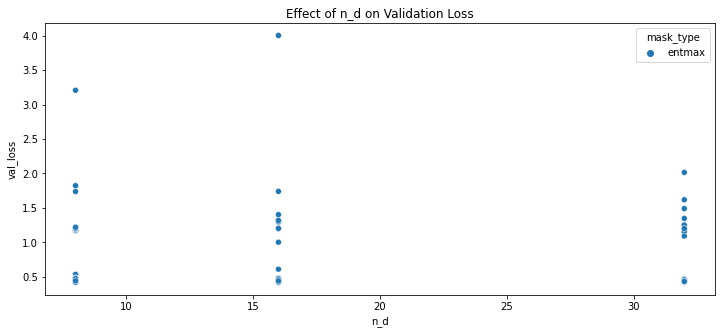

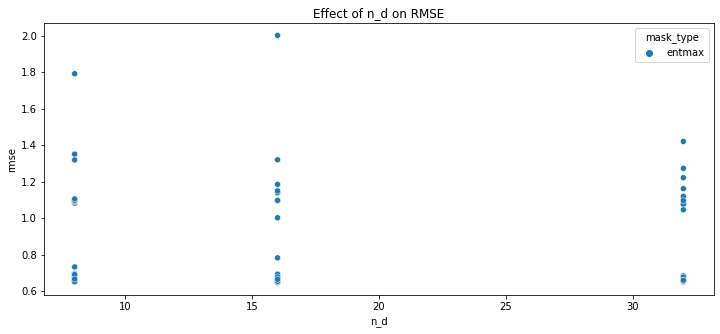

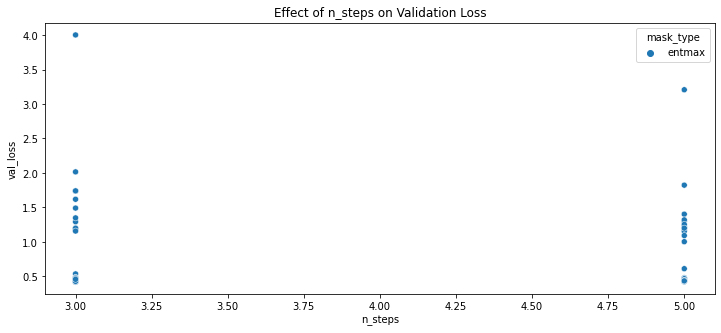

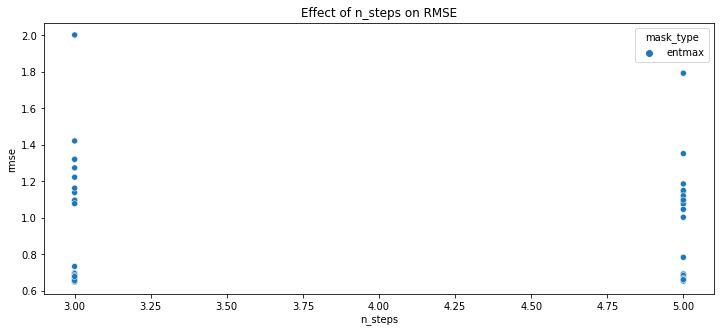

In [84]:
# Load the CSV file
results_df = pd.read_csv("tabnet_hyperparameter_search_results3.csv")

# Visualize the effect of different parameters on validation loss and RMSE
plt.figure(figsize=(12, 5))
sns.scatterplot(data=results_df, x="n_d", y="val_loss", hue="mask_type")
plt.title("Effect of n_d on Validation Loss")
plt.show()

plt.figure(figsize=(12, 5))
sns.scatterplot(data=results_df, x="n_d", y="rmse", hue="mask_type")
plt.title("Effect of n_d on RMSE")
plt.show()

plt.figure(figsize=(12, 5))
sns.scatterplot(data=results_df, x="n_steps", y="val_loss", hue="mask_type")
plt.title("Effect of n_steps on Validation Loss")
plt.show()

plt.figure(figsize=(12, 5))
sns.scatterplot(data=results_df, x="n_steps", y="rmse", hue="mask_type")
plt.title("Effect of n_steps on RMSE")
plt.show()



In [85]:
# Find the row with the minimum validation loss as the optimal parameter set
best_params = results_df.loc[results_df["val_loss"].idxmin()]
print("Best parameter combination:")
print(best_params)

Best parameter combination:
n_d                          16
n_a                          32
n_steps                       3
gamma                       1.5
lambda_sparse             0.001
optimizer_params    {'lr': 0.1}
mask_type                entmax
train_loss             0.422738
val_loss               0.418822
rmse                   0.647165
Name: 40, dtype: object


In [86]:
# Initialize the TabNet model with the optimal parameters
tabnet_model = TabNetRegressor(
    n_d=int(best_params["n_d"]),
    n_a=int(best_params["n_a"]),
    n_steps=int(best_params["n_steps"]),
    gamma=best_params["gamma"],
    lambda_sparse=best_params["lambda_sparse"],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=eval(best_params["optimizer_params"]),
    mask_type=best_params["mask_type"]
)

# Set training parameters
max_epochs = 1000
early_stopping_rounds = 10

# Train TabNet model and extract features
tabnet_model.fit(
    X_train=X_train,
    y_train=y_train_np,
    eval_set=[(X_train, y_train_np), (X_val, y_val_np)],
    max_epochs=max_epochs,
    patience=early_stopping_rounds,
    eval_metric=['rmse'],
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

Device used : cuda


epoch 0  | loss: 1.6948  | val_0_rmse: 1.10883 | val_1_rmse: 0.90326 |  0:00:00s
epoch 1  | loss: 0.6176  | val_0_rmse: 0.82326 | val_1_rmse: 0.77681 |  0:00:01s
epoch 2  | loss: 0.52568 | val_0_rmse: 0.79511 | val_1_rmse: 0.74933 |  0:00:02s
epoch 3  | loss: 0.49539 | val_0_rmse: 0.70263 | val_1_rmse: 0.70195 |  0:00:02s
epoch 4  | loss: 0.47421 | val_0_rmse: 0.68196 | val_1_rmse: 0.6797  |  0:00:03s
epoch 5  | loss: 0.4605  | val_0_rmse: 0.67659 | val_1_rmse: 0.67071 |  0:00:03s
epoch 6  | loss: 0.45299 | val_0_rmse: 0.69227 | val_1_rmse: 0.67253 |  0:00:04s
epoch 7  | loss: 0.45073 | val_0_rmse: 0.66894 | val_1_rmse: 0.68287 |  0:00:05s
epoch 8  | loss: 0.44603 | val_0_rmse: 0.66406 | val_1_rmse: 0.66569 |  0:00:05s
epoch 9  | loss: 0.43549 | val_0_rmse: 0.66093 | val_1_rmse: 0.66533 |  0:00:06s
epoch 10 | loss: 0.43188 | val_0_rmse: 0.65482 | val_1_rmse: 0.66142 |  0:00:07s
epoch 11 | loss: 0.42906 | val_0_rmse: 0.65356 | val_1_rmse: 0.65666 |  0:00:07s
epoch 12 | loss: 0.42783 | v

Best weights from best epoch are automatically used!


In [87]:
# Extract compressed features from TabNet
X_train_compressed = tabnet_model.predict(X_train)
X_val_compressed = tabnet_model.predict(X_val)
X_test_compressed = tabnet_model.predict(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_compressed, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_compressed, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_compressed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)


In [109]:
import torch.nn.functional as F

# Optimized regression model with additional layers, dropout, and batch normalization
# class OptimizedRegressionModel(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(OptimizedRegressionModel, self).__init__()
        
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 64),
#             nn.BatchNorm1d(64),
#             nn.ReLU(),
#             nn.Dropout(0.2),  # Dropout with probability 0.2
            
#             nn.Linear(64, 128),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Dropout(0.2),
            
#             nn.Linear(128, 64),
#             nn.BatchNorm1d(64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
            
#             nn.Linear(64, output_dim)
#         )

#     def forward(self, x):
#         return self.model(x)

class OptimizedRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(OptimizedRegressionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.model(x)


# Set model dimensions and output
input_dim = X_train_compressed.shape[1]
output_dim = y_train.shape[1] * 4  # Number of targets as one-hot for each column

# Initialize the optimized model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimized_regression_model = OptimizedRegressionModel(input_dim=input_dim, output_dim=output_dim).to(device)

# Use a different optimizer and learning rate scheduler
optimizer = optim.AdamW(optimized_regression_model.parameters(), lr=0.001, weight_decay=1e-5)  # AdamW with L2 regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)  # Reduce LR by half every 20 epochs
criterion = nn.CrossEntropyLoss()

# Training loop with early stopping and learning rate scheduler
epochs = 1000
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_loss = float("inf")
no_improve_rounds = 0

In [110]:
# Extract features from TabNet
X_train_compressed = tabnet_model.predict(X_train)
X_val_compressed = tabnet_model.predict(X_val)
X_test_compressed = tabnet_model.predict(X_test)

X_train_tensor = torch.tensor(X_train_compressed, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_compressed, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_compressed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# DataLoader for batch processing
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [111]:
for epoch in tqdm(range(epochs), desc="Training Optimized Regression Model"):
    optimized_regression_model.train()
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0
    
    # Training loop
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = optimized_regression_model(X_batch)
        loss = criterion(outputs.view(-1, 4), y_batch.view(-1))  # CrossEntropy loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = outputs.view(-1, 4).max(1)
        correct_train += (predicted == y_batch.view(-1)).sum().item()
        total_train += y_batch.view(-1).size(0)
    
    # Average training loss and accuracy
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation loss and accuracy
    optimized_regression_model.eval()
    with torch.no_grad():
        val_loss = 0
        correct_val = 0
        total_val = 0
        all_predictions = []
        all_targets = []
        
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = optimized_regression_model(X_batch)
            val_loss += criterion(outputs.view(-1, 4), y_batch.view(-1)).item()

            # Collect predictions and targets for confusion matrix
            _, predicted = outputs.view(-1, 4).max(1)
            all_predictions.append(predicted.cpu().numpy())
            all_targets.append(y_batch.view(-1).cpu().numpy())
            
            # Calculate validation accuracy
            correct_val += (predicted == y_batch.view(-1)).sum().item()
            total_val += y_batch.view(-1).size(0)

    # Average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Early stopping based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_rounds = 0
    else:
        no_improve_rounds += 1

    if no_improve_rounds >= 5:
        print("Early stopping for Optimized Regression Model.")
        break

    # Update learning rate scheduler
    scheduler.step()

Training Optimized Regression Model:   2%|▎         | 25/1000 [00:13<08:43,  1.86it/s]

Early stopping for Optimized Regression Model.


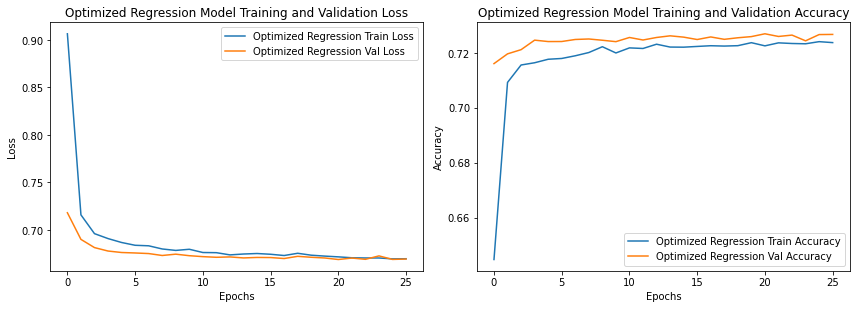

In [112]:
# Plot training and validation loss and accuracy curves
plt.figure(figsize=(12, 8))


# Optimized Regression Model Loss Curve
plt.subplot(2, 2, 1)
plt.plot(train_losses, label="Optimized Regression Train Loss")
plt.plot(val_losses, label="Optimized Regression Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Optimized Regression Model Training and Validation Loss")
plt.legend()

# Optimized Regression Model Accuracy Curve
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label="Optimized Regression Train Accuracy")
plt.plot(val_accuracies, label="Optimized Regression Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Optimized Regression Model Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [113]:
# confusion matrix
# Collect predictions and targets for confusion matrix
# Concatenate all predictions and targets for confusion matrix calculation
all_predictions = np.concatenate(all_predictions)
all_targets = np.concatenate(all_targets)

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_predictions)
print("Confusion Matrix:\n", cm)

# Calculate overall accuracy and each class's accuracy
overall_accuracy = np.trace(cm) / np.sum(cm)  # trace gives sum of diagonal elements
print(f"Overall Validation Accuracy: {overall_accuracy:.2%}")

# Calculate accuracy for each class
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for i, accuracy in enumerate(class_accuracies):
    print(f"Accuracy for class {i}: {accuracy:.2%}")


Confusion Matrix:
 [[31054  2147   440    60]
 [ 5118  6784  1079    99]
 [ 2744  1468  2494   351]
 [  831   209   904   752]]
Overall Validation Accuracy: 72.67%
Accuracy for class 0: 92.15%
Accuracy for class 1: 51.87%
Accuracy for class 2: 35.34%
Accuracy for class 3: 27.89%


In [114]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from lime import lime_tabular
from sklearn.metrics import confusion_matrix
import torch

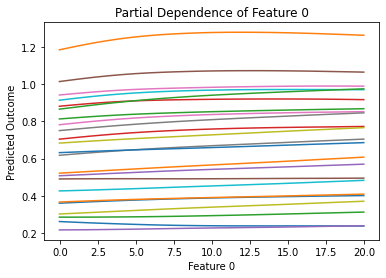

In [122]:
import numpy as np
import matplotlib.pyplot as plt

# Define a custom PDP function
def custom_pdp(model, X, feature_idx, feature_range=None, num_points=50):
    if feature_range is None:
        feature_min, feature_max = X[:, feature_idx].min(), X[:, feature_idx].max()
        feature_range = np.linspace(feature_min, feature_max, num_points)

    pdp_results = []
    X_temp = X.copy()

    for value in feature_range:
        X_temp[:, feature_idx] = value
        preds = model.predict(X_temp)
        pdp_results.append(preds.mean(axis=0))

    # Plot PDP
    plt.plot(feature_range, pdp_results)
    plt.xlabel(f"Feature {feature_idx}")
    plt.ylabel("Predicted Outcome")
    plt.title(f"Partial Dependence of Feature {feature_idx}")
    plt.show()

# Usage example with feature index 0
X_test_np = X_test if isinstance(X_test, np.ndarray) else X_test.to_numpy()
custom_pdp(tabnet_model, X_test_np, feature_idx=0)



In [124]:
# Convert X_train to numpy if it's not in the expected format for LIME
X_train_np = X_train if isinstance(X_train, np.ndarray) else X_train.to_numpy()

# Define LIME explainer
lime_explainer = lime_tabular.LimeTabularExplainer(
    X_train_np,
    feature_names=X.columns,
    class_names=[f"Class {i}" for i in range(4)],
    mode="classification"
)

# Predict function for LIME that returns probabilities
def lime_predict_fn(data):
    # Get model predictions
    preds = tabnet_model.predict(data)
    
    # Reshape preds to (batch_size, num_targets, num_classes)
    # Assuming `preds` has a shape of (batch_size, 23 * 4) and we need to reshape it to (batch_size, 23, 4)
    preds = preds.reshape(-1, 23, 4)
    
    # Apply softmax to get probabilities for each class in each target
    probabilities = np.exp(preds) / np.exp(preds).sum(axis=2, keepdims=True)  # Shape: (batch_size, 23, 4)
    
    # Flatten the probabilities to match LIME's expected single output format
    flattened_probabilities = probabilities.reshape(len(data), -1)  # Shape: (batch_size, 23 * 4)
    
    return flattened_probabilities

# LIME explanation for a single instance
exp = lime_explainer.explain_instance(X_test_np[0], lime_predict_fn, num_features=10)
exp.show_in_notebook()



                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
